In [1]:
import torch
from torchtext import data
from torchtext import datasets
import random
from matplotlib import pyplot as plt

from imp import reload
from run_helpers import *
from run import *
import torch.optim as optim

In [2]:
#Set random seed
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#Prepare data
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True,
                  pad_first=True)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [3]:
#Build vocabulary
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [4]:
#Build model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)
print(f'device name is: {device}')

device name is: cuda


In [5]:
N_EPOCHS = 20

best_valid_loss = float('inf')

train_loss_ls = []
train_acc_ls = []
valid_loss_ls = []
valid_acc_ls = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    train_loss_ls.append(train_loss)
    valid_loss_ls.append(valid_loss)
    train_acc_ls.append(train_acc)
    valid_acc_ls.append(valid_acc) 
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
test_loss, test_acc = evaluate(model, test_iterator, criterion)

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.677 | Train Acc: 56.97%
	 Val. Loss: 0.662 |  Val. Acc: 60.27%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.676 | Train Acc: 57.15%
	 Val. Loss: 0.733 |  Val. Acc: 50.94%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.656 | Train Acc: 60.80%
	 Val. Loss: 0.673 |  Val. Acc: 56.87%
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.633 | Train Acc: 63.20%
	 Val. Loss: 0.701 |  Val. Acc: 51.55%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.686 | Train Acc: 54.52%
	 Val. Loss: 0.689 |  Val. Acc: 53.15%
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.670 | Train Acc: 58.10%
	 Val. Loss: 0.665 |  Val. Acc: 58.40%
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.623 | Train Acc: 65.79%
	 Val. Loss: 0.619 |  Val. Acc: 66.38%
Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.537 | Train Acc: 74.02%
	 Val. Loss: 0.587 |  Val. Acc: 69.26%
Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.487 | Train Acc: 77.96%
	 Val. Loss: 0.580 |  Val. Acc: 70.28%
Epoch: 10 | Epoch Time: 0m 3

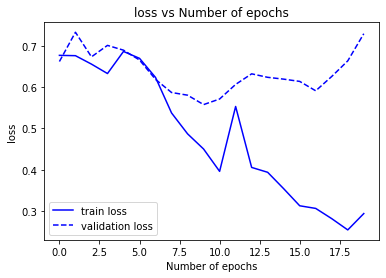

In [7]:
plt.plot(range(len(train_loss_ls)), train_loss_ls, 'b')
plt.plot(range(len(valid_loss_ls)), valid_loss_ls, 'b--')
#plt.plot(range(len(s1['ta'])), s2['tl'], 'g')
#plt.plot(range(len(s1['ta'])), np.array(s2['vl']) - np.linspace(0,0.01,300), 'g--')
#plt.plot(range(len(s1['ta'])), s3['tl'], 'r')
#plt.plot(range(len(s1['ta'])), np.array(s3['vl']) - 0.03, 'r--')
plt.xlabel("Number of epochs")
plt.ylabel("loss")
plt.title("loss vs Number of epochs")
plt.legend(['train loss', 'validation loss',])
plt.show()